In [138]:
import pandas as pd 
import numpy as np 
import os 
import datetime as dt 
import matplotlib.pyplot as plt
import geopandas as geo 
import folium 
import scipy.stats as stats

Definição de funções usadas no projeto

In [139]:
def MEDIA_MOVEL(x):

    media_movel = pd.DataFrame(x)
    l = len(x)


    media_movel['media_movel'] = None

    for i in range(7,l):
        media_movel['media_movel'][i] = (x[i-7] + x[i-6] + x[i-5] + x[i-4] + x[i-3] +x[i-2] + x[i-1])/7 

    return media_movel['media_movel']

# Lendo as bases de dados

In [141]:
df_station = pd.read_csv('./data/station.csv',index_col='station_id')
df_station.shape

(58, 8)

In [142]:
df_weather = pd.read_csv('./data/weather.csv')
df_weather.shape

(689, 21)

In [143]:
df_trips = (
    pd.read_csv('./data/trip.csv',index_col='trip_id')
    .drop_duplicates()
)
df_trips.shape

(236066, 11)

# Limpeza dos dados

In [144]:
## Clasificando colunas de data para datetime object
## TRIPS
## Start time
dates = np.array([dt.datetime.strptime(i,'%m/%d/%Y %H:%M') for i in df_trips.starttime])
df_trips.starttime = dates

## Stop time
dates = np.array([dt.datetime.strptime(i,'%m/%d/%Y %H:%M') for i in df_trips.stoptime])
df_trips.stoptime = dates

## WEATHER
dates = np.array([dt.datetime.strptime(i,'%m/%d/%Y') for i in df_weather.Date])
df_weather.Date = dates

## STATION
## install_date
dates = np.array([dt.datetime.strptime(i,'%m/%d/%Y') for i in df_station.install_date])
df_station.install_date = dates

## modification_date
df_station.modification_date.fillna(False, inplace = True)
dates = []
for i in range(len(df_station.modification_date)):
    if df_station.modification_date[i] != False:
        x = dt.datetime.strptime(df_station.modification_date[i],'%m/%d/%Y')
        dates.append(x)
    else:
        x = df_station.install_date[i]
        dates.append(x)
df_station.modification_date = dates

## Eliminando variáveis do ambiente
del dates, x

In [145]:
## Coluna com tempo da viagem
df_trips['tripduration'] = (df_trips.stoptime - df_trips.starttime)

In [146]:
df_trips.set_index('starttime').index.date

array([datetime.date(2014, 10, 13), datetime.date(2014, 10, 13),
       datetime.date(2014, 10, 13), ..., datetime.date(2016, 8, 31),
       datetime.date(2016, 8, 31), datetime.date(2016, 8, 31)],
      dtype=object)

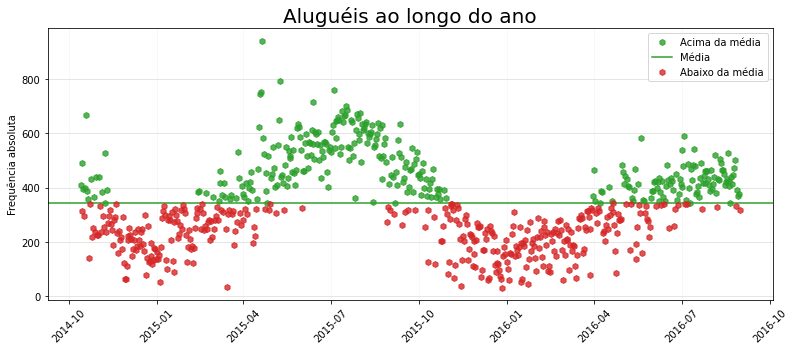

In [189]:
# Pré-processamento do plot pelo método Chaning
df_plot = (pd.read_csv('trip.csv',index_col='trip_id')
            .drop_duplicates()
            .groupby(df_trips.set_index('starttime').index.date)
            .count()
            .iloc[:,0]   
            )


df_movel = (pd.DataFrame(df_plot)
            .apply(MEDIA_MOVEL)
            )



# Plot
fig, ax = plt.subplots(figsize=(13,5))
plt.title('Aluguéis ao longo do ano', fontdict={'color':  'black', 'fontsize':20})

# Acima da média
df_plot[df_plot >= df_plot.mean()].plot(color = 'tab:green', label = 'Acima da média', linestyle ='None', marker = 'h', alpha = 0.8)

# Linha de média
plt.axhline(df_trips.groupby(df_trips.set_index('starttime').index.date).count()['bikeid'].mean(), color = 'tab:green', label ='Média')

# Abaixo da média
df_plot[df_plot < df_plot.mean()].plot(color = 'tab:red', label = 'Abaixo da média',linestyle ='None', marker = 'h', alpha = 0.8)

# Média Móvel
# plt.plot(df_movel, color = 'gray', label = 'Média Móvel')

# Parâmetros do gráfico
plt.xticks(rotation = 45)
plt.ylabel("Frequência absoluta",fontdict={'color':  'black'})
plt.grid(axis='y', alpha = 0.4)
plt.grid(axis='x', alpha = 0.1)
plt.legend();

# Eliminando dataframe do ambiente
#del df_plot

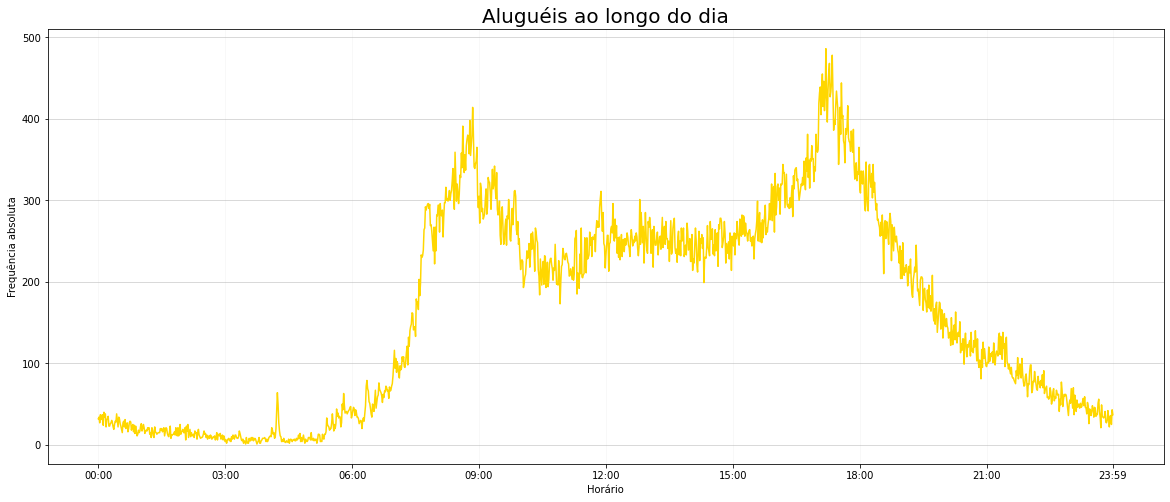

In [148]:
fig, ax = plt.subplots(figsize=(20,8))


# Plot pelo pandas
df_trips.groupby(df_trips.set_index('starttime').index.time).count()['bikeid'].plot( xticks = ['00:00','03:00','06:00', '09:00', '12:00', '15:00','18:00','21:00' ,'23:59'], label = '',color = 'gold' )

# Parâmetros do gráfico
plt.title('Aluguéis ao longo do dia', fontdict={'color':  'black', 'fontsize':20})
plt.xlabel("Horário", fontdict={'color':  'black'})
plt.ylabel("Frequência absoluta",fontdict={'color':  'black'})
plt.grid(axis='y', alpha = 0.6)
plt.grid(axis='x', alpha = 0.1);

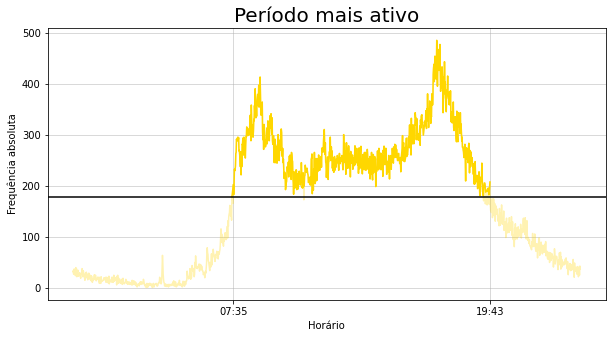

In [149]:
fig, ax = plt.subplots(figsize=(10,5))


# Plot pelo pandas
df_trips.groupby(df_trips.set_index('starttime').index.time).count()['bikeid'].plot( xticks = ['07:35','19:43'], alpha =0.3, label = '',color = 'gold' )

# Plot acima da média
df_plot = df_trips.groupby(df_trips.set_index('starttime').index.time).count()['bikeid']
df_plot[df_plot > df_plot.median()].plot(color = 'gold', label = '')

# Parâmetros do gráfico
plt.title('Período mais ativo', fontdict={'color':  'black', 'fontsize':20})
plt.xlabel("Horário", fontdict={'color':  'black'})
plt.ylabel("Frequência absoluta",fontdict={'color':  'black'})
plt.axhline(df_trips.groupby(df_trips.set_index('starttime').index.time).count()['bikeid'].median(), color ='black', label = 'Mediana')
plt.grid(axis='y', alpha = 0.6)
plt.grid(axis='x', alpha = 0.6);



In [150]:
df_trips.head()

,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,usertype,gender,birthyear
trip_id,,,,,,,,,,,
431,2014-10-13 10:31:00,2014-10-13 10:48:00,SEA00298,0 days 00:17:00,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1960.0
432,2014-10-13 10:32:00,2014-10-13 10:48:00,SEA00195,0 days 00:16:00,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1970.0
433,2014-10-13 10:33:00,2014-10-13 10:48:00,SEA00486,0 days 00:15:00,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Female,1988.0
434,2014-10-13 10:34:00,2014-10-13 10:48:00,SEA00333,0 days 00:14:00,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Female,1977.0
435,2014-10-13 10:34:00,2014-10-13 10:49:00,SEA00202,0 days 00:15:00,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1971.0


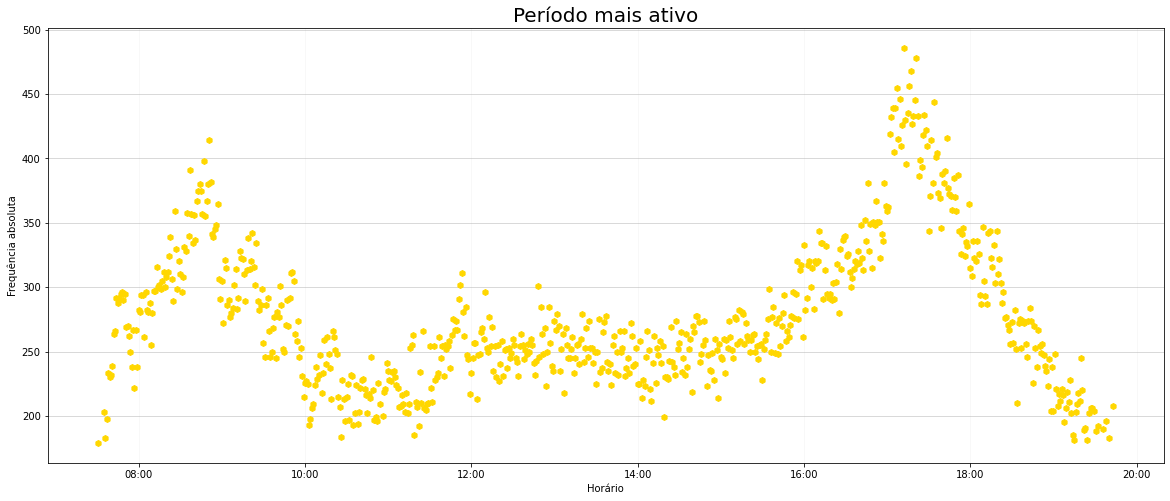

In [151]:
fig, ax = plt.subplots(figsize=(20,8))

# Plot acima da média
df_plot = df_trips.groupby(df_trips.set_index('starttime').index.time).count()['bikeid']
df_zoom =df_plot[df_plot > df_plot.median()]
df_zoom.plot(color = 'gold', linestyle ='None', marker = 'h', label = "Período mais ativo", xticks =['08:00','10:00','12:00','14:00','16:00','18:00', '20:00'])


# Parâmetros do gráfico
plt.title('Período mais ativo', fontdict={'color':  'black', 'fontsize':20})
plt.xlabel("Horário", fontdict={'color':  'black'})
plt.ylabel("Frequência absoluta",fontdict={'color':  'black'})

plt.grid(axis='y', alpha = 0.6)
plt.grid(axis='x', alpha = 0.1);

In [152]:
df_zoom.tail()

19:32:00    192
19:36:00    190
19:38:00    196
19:40:00    183
19:43:00    208
Name: bikeid, dtype: int64

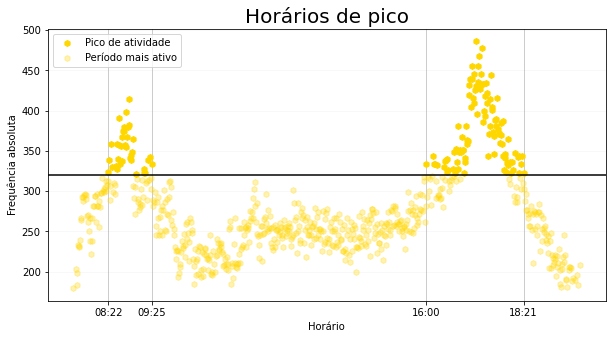

In [153]:
fig, ax = plt.subplots(figsize=(10,5))


# Plot acima da média
df_plot = df_trips.groupby(df_trips.set_index('starttime').index.time).count()['bikeid']
df_zoom =df_plot[df_plot > df_plot.median()]
df_zoom[df_zoom > 320].plot(color = 'gold', label = 'Pico de atividade', xticks = ['08:22','09:25', '16:00','18:21' ], linestyle ='None', marker = 'h')
df_zoom[df_zoom < 320].plot(color = 'gold',alpha = 0.3, linestyle ='None', marker = 'h', label = "Período mais ativo")


# Parâmetros do gráfico
plt.title('Horários de pico', fontdict={'color':  'black', 'fontsize':20})
plt.xlabel("Horário", fontdict={'color':  'black'})
plt.ylabel("Frequência absoluta",fontdict={'color':  'black'})
plt.grid(axis='y', alpha = 0.1)
plt.grid(axis='x', alpha = 0.8)
plt.axhline(320, color = 'black')

plt.legend();


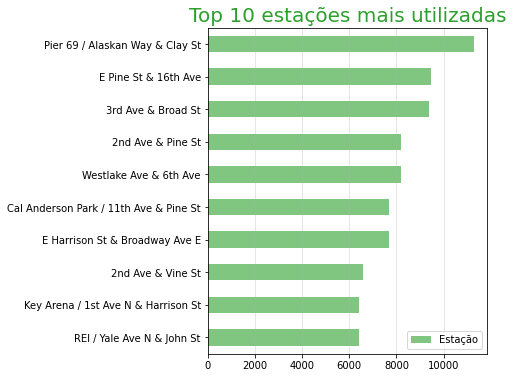

In [154]:
plt.figure(figsize = (5,6))

df_trips.groupby('from_station_name').count()['starttime'].sort_values(ascending = True).tail(10).plot.barh(color = 'tab:green', alpha = 0.6, label = 'Estação');

plt.title('Top 10 estações mais utilizadas', fontdict = {'color':'tab:green', 'fontsize': 20})
plt.ylabel('') 
plt.grid(axis ='x', alpha = 0.4)
# plt.axvline(df_trips.groupby('from_station_name').count()['starttime'].sort_values(ascending = False).mean(), color = 'tab:green', label = 'Média das 10 estações')
plt.legend();


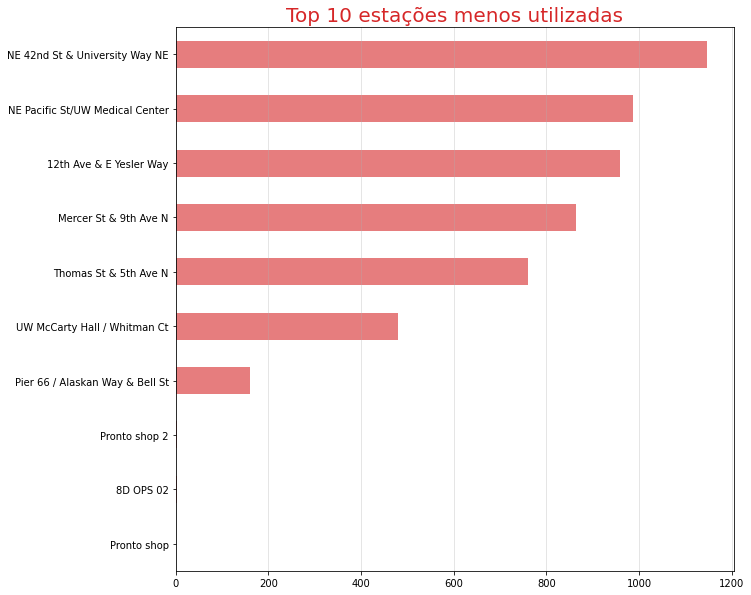

In [155]:
plt.figure(figsize = (10,10))

df_trips.groupby('from_station_name').count()['starttime'].sort_values(ascending = True).head(10).plot.barh(color = 'tab:red', alpha = 0.6);

plt.title('Top 10 estações menos utilizadas', fontdict = {'color':'tab:red', 'fontsize': 20})
plt.ylabel('') 
plt.grid(axis ='x', alpha = 0.4);

In [156]:
# Média de aluguéis por estação

media = round(df_trips.groupby('from_station_name').count()['starttime'].mean())

print(f'A média de aluguéis por estação é {media}')

del media

A média de aluguéis por estação é 3870


## Plot dos mapas

In [157]:

# Adicionando colunas de freq de uso
freq_saidas = df_trips[['from_station_id', 'usertype']].groupby('from_station_id').count()
freq_chegadas = df_trips[['to_station_id', 'gender']].groupby('to_station_id').count()




## Criando GeoDataFrame 

In [158]:
# Colocando estatísticas de uso no df_station
df_station= df_station.merge(freq_saidas, left_on= df_station.index, right_on = freq_saidas.index)
df_station.set_index('key_0', inplace = True)
df_station= df_station.merge(freq_chegadas, left_on= df_station.index, right_on = freq_chegadas.index)
df_station.set_index('key_0', inplace = True)
df_station.rename(columns = {'usertype': 'freq saidas', 'gender': 'freq_chegadas'}, inplace = True)

geo_station = geo.GeoDataFrame(df_station, geometry = geo.points_from_xy(df_station.long, df_station.lat))

In [159]:
geo_station.head()

,name,lat,long,install_date,install_dockcount,modification_date,current_dockcount,decommission_date,freq saidas,freq_chegadas,geometry
key_0,,,,,,,,,,,
BT-01,3rd Ave & Broad St,47.618418,-122.350964,2014-10-13,18,2014-10-13,18,NaN,9392,3570,POINT (-122.35096 47.61842)
BT-03,2nd Ave & Vine St,47.615829,-122.348564,2014-10-13,16,2014-10-13,16,NaN,6568,3526,POINT (-122.34856 47.61583)
BT-04,6th Ave & Blanchard St,47.616094,-122.341102,2014-10-13,16,2014-10-13,16,NaN,3819,2507,POINT (-122.34110 47.61609)
BT-05,2nd Ave & Blanchard St,47.613110,-122.344208,2014-10-13,14,2014-10-13,14,NaN,4986,2740,POINT (-122.34421 47.61311)
CBD-03,7th Ave & Union St,47.610731,-122.332447,2014-10-13,20,2014-10-13,20,NaN,4210,3507,POINT (-122.33245 47.61073)


In [160]:
df_trips.head()

,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,usertype,gender,birthyear
trip_id,,,,,,,,,,,
431,2014-10-13 10:31:00,2014-10-13 10:48:00,SEA00298,0 days 00:17:00,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1960.0
432,2014-10-13 10:32:00,2014-10-13 10:48:00,SEA00195,0 days 00:16:00,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1970.0
433,2014-10-13 10:33:00,2014-10-13 10:48:00,SEA00486,0 days 00:15:00,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Female,1988.0
434,2014-10-13 10:34:00,2014-10-13 10:48:00,SEA00333,0 days 00:14:00,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Female,1977.0
435,2014-10-13 10:34:00,2014-10-13 10:49:00,SEA00202,0 days 00:15:00,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1971.0


# Localização das estações mais utilizadas

In [161]:
map_3 = folium.Map(location= [geo_station.geometry.y[0], geo_station.geometry.x[0]], zoom_start= 13)
freq_mean =geo_station['freq saidas'].mean()
freq_std = geo_station['freq saidas'].std()

for i in geo_station.geometry:
    freq = geo_station[geo_station.geometry == i]['freq saidas'].values
    station = geo_station[geo_station.geometry == i].index.values
    tooltip = f'Station:{station} \t Users:{freq}'
    if geo_station[geo_station.geometry == i]['freq saidas'].values > (freq_mean + freq_std):
        color = 'darkgreen'
        folium.Marker([i.y, i.x], tooltip=tooltip, icon=folium.Icon(color=color, icon='info-sign')).add_to(map_3)

    else:
        continue
    

map_3

# Localização das estações menos utilizadas

In [162]:
map_4 = folium.Map(location= [geo_station.geometry.y[0], geo_station.geometry.x[0]], zoom_start= 13)
freq_mean =geo_station['freq saidas'].mean()
freq_std = geo_station['freq saidas'].std()

for i in geo_station.geometry:
    tooltip = geo_station[geo_station.geometry == i]['freq saidas'].values
    
    if geo_station[geo_station.geometry == i]['freq saidas'].values < (freq_mean - freq_std):
        color = 'darkred'
        folium.Marker([i.y, i.x], tooltip=tooltip, icon=folium.Icon(color=color, icon='info-sign')).add_to(map_4)
    else:
        continue
    

map_4

## Descrição de grupos de usuários

In [163]:
df_trips.head()

,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,usertype,gender,birthyear
trip_id,,,,,,,,,,,
431,2014-10-13 10:31:00,2014-10-13 10:48:00,SEA00298,0 days 00:17:00,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1960.0
432,2014-10-13 10:32:00,2014-10-13 10:48:00,SEA00195,0 days 00:16:00,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1970.0
433,2014-10-13 10:33:00,2014-10-13 10:48:00,SEA00486,0 days 00:15:00,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Female,1988.0
434,2014-10-13 10:34:00,2014-10-13 10:48:00,SEA00333,0 days 00:14:00,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Female,1977.0
435,2014-10-13 10:34:00,2014-10-13 10:49:00,SEA00202,0 days 00:15:00,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1971.0


Text(0, 0.5, '')

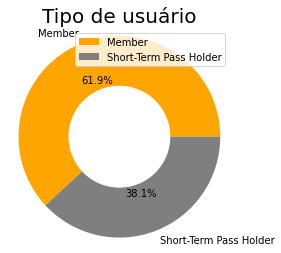

In [164]:
# Gráfico de DONUT
circle = plt.Circle((0,0),0.5, color = 'white')
df_trips[['usertype','bikeid']].groupby('usertype').count().plot.pie(subplots=True, figsize = (4,4), autopct = '%1.1f%%', colors = ['orange', 'tab:gray'])
plt.title('Tipo de usuário', fontdict = {'fontsize':20})
plt.gca().add_artist(circle)
plt.axis('equal')
plt.ylabel('')


Text(0.5, 1.0, 'Gênero dos membros')

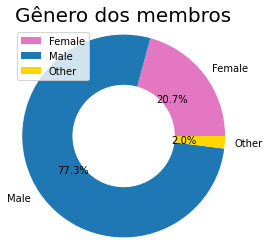

In [165]:
# Distribuição de gênero dos membros
circle = plt.Circle((0,0),0.5, color = 'white')
df_trips[['gender','bikeid']].groupby('gender').count().plot.pie(subplots = True, figsize = (4,4), colors =['tab:pink','tab:blue', 'gold'], autopct = '%1.1f%%')
plt.gca().add_artist(circle)
plt.axis('equal')
plt.ylabel('')
plt.title('Gênero dos membros', fontdict = {'fontsize':20})


In [166]:
df_trips.columns

Index(['starttime', 'stoptime', 'bikeid', 'tripduration', 'from_station_name',
       'to_station_name', 'from_station_id', 'to_station_id', 'usertype',
       'gender', 'birthyear'],
      dtype='object')

In [167]:
# Criando coluna com idade dos membros
df_trips['Age'] = 2020 - df_trips.birthyear

(0.0, 100.0)

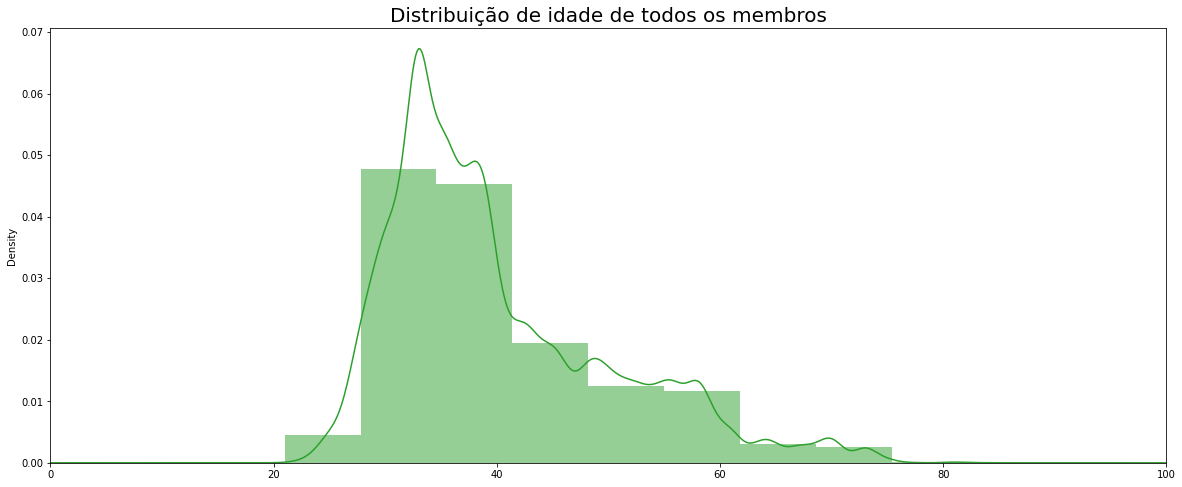

In [168]:
df_trips.Age.plot.hist(density = True, figsize = (20,8), color = 'tab:green', alpha = 0.5)
plt.title('Distribuição de idade de todos os membros', fontdict = {'fontsize':20})
df_trips.Age.plot.kde(color = 'tab:green')
plt.xlim(0,100)

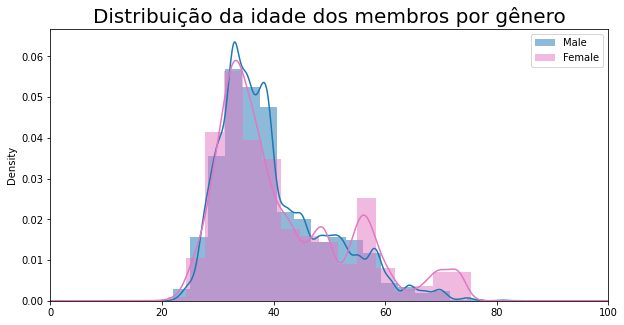

In [169]:
fig, ax = plt.subplots(figsize=(10,5))

df_trips.query("gender == 'Male'").Age.plot.hist(density = True, color = 'tab:blue', alpha = 0.5, label = 'Male', bins = 20)
df_trips.query("gender == 'Female'").Age.plot.hist(density = True, color = 'tab:pink', alpha = 0.5, label = 'Female', bins = 20)
df_trips.query("gender == 'Male'").Age.plot.kde(color = 'tab:blue', label = '')
df_trips.query("gender == 'Female'").Age.plot.kde(color = 'tab:pink', label ='')
plt.xlim(0,100)
plt.title('Distribuição da idade dos membros por gênero', fontdict = {'fontsize':20})
plt.legend()

In [170]:
# Calculando terceiro quartil de idade
np.percentile(df_trips.Age.dropna(), 75)

45.0

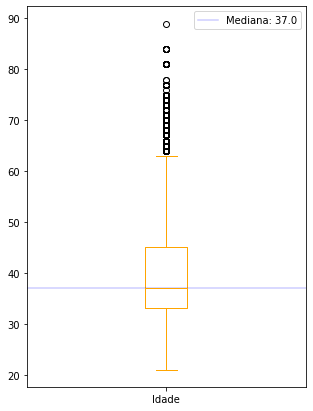

In [171]:
## Boxplot com idade dos membros

df_trips.Age.plot.box( figsize = (5,7), color = 'orange', vert = True, label = 'Idade')
# plt.title('Boxplot', fontdict = {'fontsize':20})
mediana = df_trips.Age.median()
plt.axhline(mediana, color = 'blue', alpha = 0.2, label =f'Mediana: {mediana}')
plt.legend()

In [172]:
indices = [df_trips[['from_station_id','usertype', 'bikeid']].groupby(['from_station_id','usertype']).count().index[i][0] for i in range(len(df_trips[['from_station_id','usertype', 'bikeid']].groupby(['from_station_id','usertype']).count().index))]
indices = list(set(indices))

# Mapa para time de marketing

In [173]:
## Mapa de proporção de mebros nas estações

map = folium.Map(location= [geo_station.geometry.y[0], geo_station.geometry.x[0]], zoom_start= 13)
freq_mean =geo_station['freq saidas'].mean()
freq_std = geo_station['freq saidas'].std()

for i in geo_station.geometry:
    tooltip = geo_station[geo_station.geometry == i]['name'].values

    # Definindo variáveis do html
    id_station_html = str(geo_station[geo_station.geometry == i].index.values[0]).replace('-','&#8209;')
    id_station = geo_station[geo_station.geometry == i].index.values[0]
    mask = (df_trips.from_station_id == id_station)
    membros = df_trips[mask].groupby('usertype').count()['bikeid']
    genero = df_trips[mask].groupby('gender').count()['bikeid']
    faixa_etaria = df_trips[mask].Age.dropna()
    
    if  round(membros[0]/membros.sum() * 100,2) > 50 and geo_station[geo_station.geometry == i]['freq saidas'].values > (freq_mean ):
        color = 'darkgreen'
    elif round(membros[0]/membros.sum() * 100,2) > 50:
        color = 'lightgreen'
    else:
        color ='lightred'
    
    folium.Marker([i.y, i.x], popup =folium.Popup(f'<h4>{id_station_html}</h4>  <hr>  <p>Users: {membros.sum()} <hr>Membros: {round(membros[0]/membros.sum() * 100,2)}%</p> <p>Homens: {round(genero.Male/genero.sum() *100,2)}% <hr>Idade: {np.quantile(faixa_etaria,0)} a {np.quantile(faixa_etaria,0.75)}', parse_html = False), tooltip=tooltip, icon=folium.Icon(color=color, icon='info-sign'), encoding = 'utf-8').add_to(map)

map.save(outfile = 'Membros.html')

map

# Mapa para time de operações

In [174]:
## Mapa para o time de operações

map_2 = folium.Map(location= [geo_station.geometry.y[0], geo_station.geometry.x[0]], zoom_start= 13)
# Estatísticas de uso
freq_mean =geo_station['freq saidas'].mean()
freq_std = geo_station['freq saidas'].std()

for i in geo_station.geometry:
    tooltip = geo_station[geo_station.geometry == i]['name'].values
    
    # Definindo variáveis do html do popup
    id_station_html = str(geo_station[geo_station.geometry == i].index.values[0]).replace('-','&#8209;')
    id_station = geo_station[geo_station.geometry == i].index.values[0]
    # Aluguéis
    mask = (df_trips.from_station_id == id_station)
    alugueis = df_trips[mask].groupby('usertype').count()['bikeid']
    # Depósitos
    mask_2 = (df_trips.to_station_id == id_station)
    depositos = df_trips[mask_2].groupby('usertype').count()['bikeid']
    # Top 3 maiores destinos
    destinos = df_trips.groupby(['from_station_id','to_station_id']).count()['bikeid'].loc[id_station].sort_values(ascending = False).index
    destinos_1 = destinos[0].replace('-','&#8209;')
    destinos_2 = destinos[1].replace('-','&#8209;')
    destinos_3 = destinos[2].replace('-','&#8209;')
    # Top 3 maiores chegadas
    chegadas = df_trips.groupby(['to_station_id','from_station_id']).count()['bikeid'].loc[id_station].sort_values(ascending = False).index
    chegadas_1 = chegadas[0].replace('-','&#8209;')
    chegadas_2 = chegadas[1].replace('-','&#8209;')
    chegadas_3 = chegadas[2].replace('-','&#8209;')

    # Definindo critério para cores dos marcadores
    if (geo_station[geo_station.geometry == i]['freq saidas'].values > (freq_mean + freq_std)):
        color = 'darkgreen'
    elif (geo_station[geo_station.geometry == i]['freq saidas'].values > (freq_mean )):
        color = 'lightgreen'
    elif (geo_station[geo_station.geometry == i]['freq saidas'].values < (freq_mean - freq_std)):
        color = 'darkred'
    else:
        color ='lightred'
    
    folium.Marker([i.y, i.x], popup =folium.Popup(f'<h4>{id_station_html}</h4>  <hr>  <p>Alugueis: {alugueis.sum()} Depositos: {depositos.sum()}</p> <hr> <h5> Maiores destinos </h5>  <p>1&#8209;{destinos_1} 2&#8209;{destinos_2} 3&#8209;{destinos_3} </p> <hr> <h5>Maiores chegadas </h5><p>1&#8209;{chegadas_1} 2&#8209;{chegadas_2} 3&#8209;{chegadas_3}</p>', parse_html = False), tooltip=tooltip, icon=folium.Icon(color=color, icon='info-sign'), encoding = 'utf-8').add_to(map_2)

map_2.save("Operações.html")
map_2


## Análise do clima

In [175]:
df_weather.T

,0,1,2,3,4,5,6,7,8,9,...,679,680,681,682,683,684,685,686,687,688
Date,2014-10-13 00:00:00,2014-10-14 00:00:00,2014-10-15 00:00:00,2014-10-16 00:00:00,2014-10-17 00:00:00,2014-10-18 00:00:00,2014-10-19 00:00:00,2014-10-20 00:00:00,2014-10-21 00:00:00,2014-10-22 00:00:00,...,2016-08-22 00:00:00,2016-08-23 00:00:00,2016-08-24 00:00:00,2016-08-25 00:00:00,2016-08-26 00:00:00,2016-08-27 00:00:00,2016-08-28 00:00:00,2016-08-29 00:00:00,2016-08-30 00:00:00,2016-08-31 00:00:00
Max_Temperature_F,71,63,62,71,64,68,73,66,64,60,...,72,79,82,93,88,72,75,81,70,71
Mean_Temperature_F,62,59,58,61,60,64,64,60,58,58,...,64,67,70,77,74,66,68,68,64,65
Min_TemperatureF,54,55,54,52,57,59,55,55,55,57,...,57,55,57,61,60,61,59,55,57,59
Max_Dew_Point_F,55,52,53,49,55,59,57,57,52,55,...,59,55,57,59,57,57,54,55,55,61
MeanDew_Point_F,51,51,50,46,51,57,55,54,49,53,...,51,51,55,54,52,54,52,53,53,56
Min_Dewpoint_F,46,50,46,42,41,55,53,50,46,48,...,46,48,54,50,45,50,50,50,52,52
Max_Humidity,87,88,87,83,87,90,94,90,87,88,...,93,83,89,81,82,81,80,89,83,90
Mean_Humidity,68,78,77,61,72,83,74,78,70,81,...,64,58,60,51,45,65,65,65,69,77
Min_Humidity,46,63,67,36,46,68,52,67,58,67,...,40,39,39,22,22,46,44,39,53,63


In [176]:
# Definindo DateTime Index
df_weather.set_index('Date', inplace = True)

Text(0.5, 0, '')

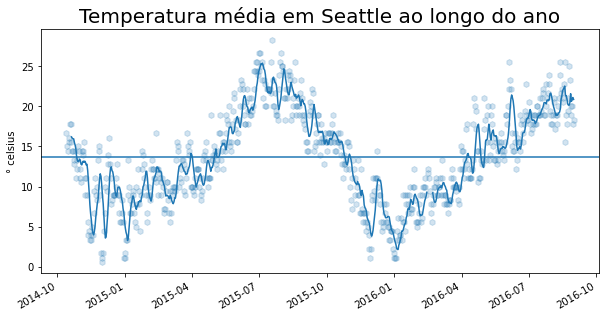

In [177]:
# Convertendo temperatura para Celsius
df_celsius = df_weather.Mean_Temperature_F.apply(lambda x: (x-32)/1.8)

df_movel = (pd.DataFrame(df_celsius)
            .apply(MEDIA_MOVEL)
            )

plt.plot(df_movel, color = 'tab:blue', label = 'Média Móvel')

df_celsius.plot(figsize = (10,5), linestyle = 'None', marker  ='h', alpha = 0.2)
plt.axhline(df_weather.Mean_Temperature_F.apply(lambda x: (x-32)/1.8).mean(), label = 'Média')
plt.title('Temperatura média em Seattle ao longo do ano', fontdict = {'fontsize':20})
plt.ylabel('° celsius')
plt.xlabel('')

Text(0, 0.5, 'mm de água')

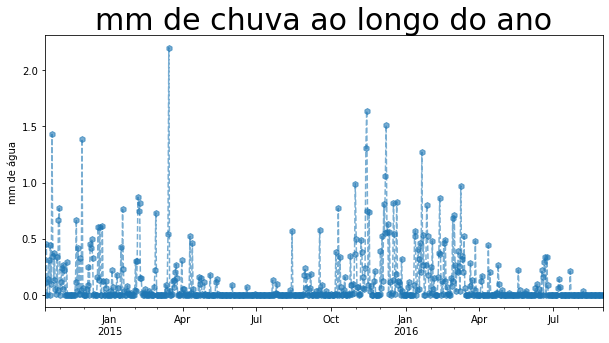

In [178]:
df_weather.Precipitation_In.plot(figsize = (10,5), linestyle = '--', marker  ='h', alpha = 0.6)	
plt.title('mm de chuva ao longo do ano', fontdict= {'fontsize':30})
plt.xlabel('')
plt.ylabel('mm de água')


In [179]:
df_weather.columns

Index(['Max_Temperature_F', 'Mean_Temperature_F', 'Min_TemperatureF',
       'Max_Dew_Point_F', 'MeanDew_Point_F', 'Min_Dewpoint_F', 'Max_Humidity',
       'Mean_Humidity', 'Min_Humidity', 'Max_Sea_Level_Pressure_In',
       'Mean_Sea_Level_Pressure_In', 'Min_Sea_Level_Pressure_In',
       'Max_Visibility_Miles', 'Mean_Visibility_Miles', 'Min_Visibility_Miles',
       'Max_Wind_Speed_MPH', 'Mean_Wind_Speed_MPH', 'Max_Gust_Speed_MPH',
       'Precipitation_In', 'Events'],
      dtype='object')

In [180]:
df_weather['Alugueis'] = df_trips.groupby(df_trips.set_index('starttime').index.date).count()['starttime']

In [181]:
df_weather.corr()['Alugueis'].sort_values(ascending = False)

Alugueis                      1.000000
Max_Temperature_F             0.786471
Mean_Temperature_F            0.749565
Min_TemperatureF              0.640299
Min_Visibility_Miles          0.469678
MeanDew_Point_F               0.451536
Max_Dew_Point_F               0.432885
Min_Dewpoint_F                0.395781
Mean_Visibility_Miles         0.364015
Min_Sea_Level_Pressure_In     0.179864
Mean_Sea_Level_Pressure_In    0.078713
Max_Visibility_Miles          0.058050
Max_Sea_Level_Pressure_In    -0.065124
Max_Wind_Speed_MPH           -0.259274
Mean_Wind_Speed_MPH          -0.263601
Precipitation_In             -0.439760
Max_Humidity                 -0.579206
Min_Humidity                 -0.648008
Mean_Humidity                -0.679630
Name: Alugueis, dtype: float64

Text(0.5, 0, '')

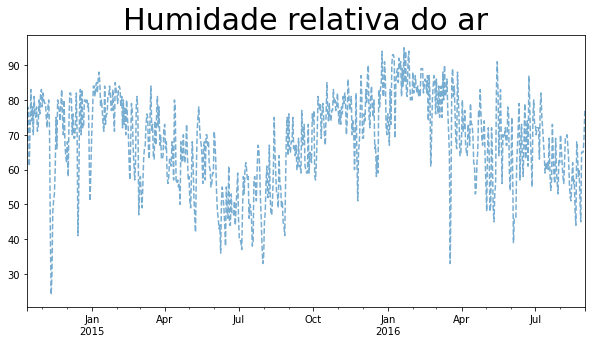

In [182]:

df_weather.Mean_Humidity.plot(figsize = (10,5), linestyle = '--', alpha = 0.6)
plt.title('Humidade relativa do ar', fontdict = {'fontsize':30})
plt.xlabel('')

In [187]:
df_corr = pd.DataFrame(data=df_celsius.values,index=df_celsius.index, columns= ['Temp_media_celsius'])

df_corr['Precipitation_In'] = df_weather['Precipitation_In']

df_corr['Mean_Humidity'] = df_weather['Mean_Humidity']

df_corr['Alugueis'] = df_trips.groupby(df_trips.set_index('starttime').index.date).count()['starttime']

df_corr

,Temp_media_celsius,Precipitation_In,Mean_Humidity,Alugueis
Date,,,,
2014-10-13,16.666667,0.00,68,409
2014-10-14,15.000000,0.11,78,491
2014-10-15,14.444444,0.45,77,313
2014-10-16,16.111111,0.00,61,395
2014-10-17,15.555556,0.14,72,294
...,...,...,...,...
2016-08-27,18.888889,0.00,65,333
2016-08-28,20.000000,0.00,65,392
2016-08-29,20.000000,0.00,65,369


In [188]:
# Correlaao entre Aluguéis e tempo
df_corr.corr()

,Temp_media_celsius,Precipitation_In,Mean_Humidity,Alugueis
Temp_media_celsius,1.000000,-0.194528,-0.584973,0.749565
Precipitation_In,-0.194528,1.000000,0.419802,-0.439760
Mean_Humidity,-0.584973,0.419802,1.000000,-0.679630
Alugueis,0.749565,-0.439760,-0.679630,1.000000
